In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time

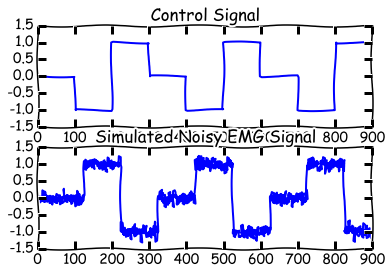

In [79]:
plt.xkcd()  # Yes...

tmax = 900

t = tmax*np.linspace(0, 1, tmax, endpoint=False)

contSig = np.zeros(tmax)

step = 300
for i in range(0, tmax, step):
    contSig[i:i+100] = 0
    contSig[i+100:i+200] = -1
    contSig[i+200:i+300] = 1

# Two subplots, unpack the axes array immediately
plt.figure(figsize=(40,40))
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)

ax1.plot(t, contSig)
ax1.set_ylim([-1.5, 1.5])
ax1.set_title('Control Signal')

delay = 25
simEMG = [0] * (tmax+delay)

for i in range(1,tmax):
    if contSig[i] == 0:
        simEMG[i + delay] = 0
    elif contSig[i] == -1:
        simEMG[i + delay] = 1
    elif contSig[i] == 1:
        simEMG[i + delay] = -1
        
noise = np.random.normal(0,0.1,tmax)

ax2.plot(t, simEMG[0:tmax]+noise)
ax2.set_ylim(-1.5, 1.5)
ax2.set_title('Simulated Noisy EMG Signal')

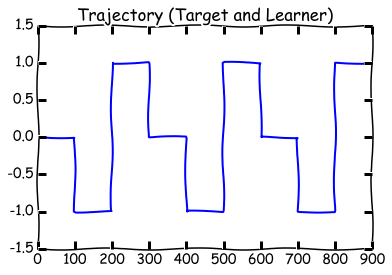

In [105]:
# Implement a learning algorithm to try to fit the signal

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t, contSig)
ax1.set_ylim(-1.5, 1.5)
ax1.set_title('Trajectory (Target and Learner)')

learnedSig = np.zeros(tmax)

# Initialize the weight vectors
wU = np.zeros(tmax)
wS = np.zeros(tmax)
v = np.zeros(tmax)
elU = np.zeros(tmax)
elS = np.zeros(tmax)
elV = np.zeros(tmax)

# Initialize the state array for the trajectory
s = np.array([0,0])
newS = np.array([0,0])

gam = 0.99

x = np.zeros(tmax)
xNew = np.zeros(tmax)

alpha = 0.1
alphaV = 0.1
alphaW = 0.1

stdC = 1
r = 0

agentMean = 0
agentStd = 0

def featurize(s):
    
    x = 0
    
    # use a representation to get a featurized state space
    if (s[0] > 0.5 and s[1] > 0.5):
        x = 1
    elif (s[0] < 0.5 and s[1] > 0.5):
        x = 0.5
    elif (s[0] > 0.5 and s[1] < 0.5):
        x = -0.5
    else 
        x = 0
    
    return x

def perform(a):
    
    # take the action and observe the new state and the reward 
    r = 1
    newS = np.array([np.random.normal(0,1),np.random.normal(0,1)])
    
    return r,newS

for i in range(tmax):

    x = featurize(s)
    
    agentMean = np.dot(wU,x)
    agentStd = np.exp(np.dot(wS,x) + np.log(stdC))
    
    # get the action from the normal distribution
    a = np.random.normal(mean,std)
 
    # take action a and observe the reward, r, and the new state, newS
    r,newS = perform(a)
    
    delta = r + gam * np.dot(v,xNew) - np.dot(v,x)
    elV = gam * elV + x
    v = v + alphaV * delta * elV
    elU = gam * elU + (alpha - mean) * x
    wU = wU + alphaW * delta * elU
    elS = gam * elS + (np.power((alpha - mean),2) / np.power(std,2) - 1) * x
    wS = wS + alphaW * delta * elS
    
    s = newS

